# Estimating Wins from Offensive and Defensive Rating Ranks

##### By: Ford Higgins

As part of the season previews on the Dunc'd On podcast, Nate Duncan tends to use a heuristic for the number of games he expects a team to win that year. He predicts where he expects them to finish in the rankings for offensive and defensive rating, and backs into an expected win total from those ranks. In other words, given rankings for a team's offensive and defensive ratings, could we estimate an expected number of wins for that team? This model attempts to do just that using NBA data since the 1996-97 season (aka the start of leaguewide play-by-play data) to use in a linear regression. I conclude with a few visualizations and some caveats as to why this model should be treated solely as a heuristic and not a more rigorous system for season predictions. 

### Imports

Here I am importing the relevant packages and a couple of custom objects and functions from my other files.

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time

from nba_headers import nba_headers, nba_params
from nba_functions import write_nba_data, scrape_nba_stats

### Data Acquisition and Cleaning

In [2]:
base_url = "http://stats.nba.com/stats/leaguedashteamstats"
nba_params['MeasureType'] = 'Advanced'
df = scrape_nba_stats(base_url=base_url, headers=nba_headers, params=nba_params, year_start=1996, year_end=2017)

In [3]:
write_nba_data(df, 'nba_tadv.csv')

Reloading and previewing the data.

In [4]:
df = pd.read_csv('../../data/nba_tadv.csv')

df.head()

,Season,Team_Id,Team_Name,Gp,W,L,W_Pct,Min,E_Off_Rating,Off_Rating,...,Oreb_Pct_Rank,Dreb_Pct_Rank,Reb_Pct_Rank,Tm_Tov_Pct_Rank,Efg_Pct_Rank,Ts_Pct_Rank,Pace_Rank,Pie_Rank,Cfid,Cfparams
0,1997,1610612737,Atlanta Hawks,82,56,26,0.683,3961.0,105.4,106.3,...,14,9,8,12,12,12,26,4,10,Atlanta Hawks
1,1997,1610612738,Boston Celtics,82,15,67,0.183,3981.0,100.8,102.8,...,17,19,27,11,24,24,2,28,10,Boston Celtics
2,1997,1610612766,Charlotte Hornets,82,54,28,0.659,3961.0,108.0,109.1,...,27,16,20,5,3,2,22,10,10,Charlotte Hornets
3,1997,1610612741,Chicago Bulls,82,69,13,0.841,3946.0,111.1,112.4,...,2,10,2,2,5,7,17,2,10,Chicago Bulls
4,1997,1610612739,Cleveland Cavaliers,82,42,40,0.512,3971.0,102.0,102.7,...,25,5,16,14,15,18,29,13,10,Cleveland Cavaliers


I only need the `W_Pct`, `Off_Rating_Rank`, and `Def_Rating_Rank` columns for my regression, so I pull them out using pandas `loc` accessor and copy the dataframe to make sure I am not resetting values for the existing dataframe in my later computations.

In [5]:
df_new = df.loc[:, ['W_Pct', 'Off_Rating_Rank', 'Def_Rating_Rank']].copy()

df_new.head()

,W_Pct,Off_Rating_Rank,Def_Rating_Rank
0,0.683,9,3
1,0.183,22,27
2,0.659,4,22
3,0.841,1,4
4,0.512,24,5


### Fitting the Regression

I assign the `W_Pct` column as the dependent variable and the `Off_Rating_Rank` and `Def_Rating_Rank` as the independent variables and use scikit-learn's `LinearRegression()` function for the regression. This function makes it easy to fit the model and find our estimated values for winning percentage using the previously seen combinations of ratings rankings. Future iterations may switch to using the statsmodels package so confidence intervals could be included in the estimations. 

In [6]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

X = df_new.drop('W_Pct', axis = 1)
y = df_new.W_Pct

lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [7]:
pred_w_pct = lr.predict(X)
df_new['pred_w_pct'] = pred_w_pct
df_new['pred_wins'] = np.round(82*pred_w_pct, 1)

df_new.head()

,W_Pct,Off_Rating_Rank,Def_Rating_Rank,pred_w_pct,pred_wins
0,0.683,9,3,0.705638,57.9
1,0.183,22,27,0.297266,24.4
2,0.659,4,22,0.557359,45.7
3,0.841,1,4,0.786383,64.5
4,0.512,24,5,0.512329,42.0


This process can be streamlined by writing custom functions that can return either a predicted wins number or a predicted winning percentage. The first function, `pred_wins_by_rating_rank()`, can be used with the pre-fit model and arbitrary rankings for each rating, and will return the predicted wins/winning percentage for that specific combination. The second function, `pred_wins_by_rating_rank_grid()`, performs the same task on a grid of all possible combinations of rankings (900 total) and returns a dataframe with the predicted wins/winning percentage.

In [8]:
def pred_wins_by_rating_ranks(pred_o_rating, pred_d_rating, model, wins = True):
    """
    Estimates wins/win percentage given a pre-trained model and predicted ranks for 
    offensive and defensive ratings.
    :pred_o_rating: Integer between 1 and 30 for predicted offensive rating rank
    :pred_d_rating: Integer between 1 and 30 for predicted defensive rating rank
    :model: pre-trained model on rating ranks and win percentage
    :wins: if True, return number of wins. If False, return winning percentage
    """
    rank_array = np.array([pred_o_rating, pred_d_rating]).reshape(1, -1)
    pred = model.predict(rank_array)
    return np.round(82*pred, 1) if wins else np.round(pred, 1)


def pred_wins_by_rating_rank_grid(model, wins = True):
    """
    Estimates wins/win percentage for all combinations of ranks for offensive and 
    defensive ratings.
    :model: pre-trained model on rating ranks and win percentage
    :wins: if True, return number of wins. If False, return winning percentage
    """
    from itertools import product
    ranking_grid = [x for x in product(np.arange(1, 31), np.arange(1, 31))]
    preds = np.round(82*model.predict(ranking_grid), 1) if wins else np.round(model.predict(ranking_grid), 3)
    df = pd.DataFrame(ranking_grid, columns=['Off_Rating_Rank', 'Def_Rating_Rank'])
    df['Preds'] = preds
    return df

Creating the dataframe of all possible combinations of rankings and the corresponding predicted wins. 

In [9]:
ranking_wins_df = pred_wins_by_rating_rank_grid(lr)

ranking_wins_df.head()

,Off_Rating_Rank,Def_Rating_Rank,Preds
0,1,1,67.1
1,1,2,66.3
2,1,3,65.4
3,1,4,64.5
4,1,5,63.6


In [10]:
ranking_wins_df.tail()

,Off_Rating_Rank,Def_Rating_Rank,Preds
895,30,26,17.8
896,30,27,16.9
897,30,28,16.0
898,30,29,15.1
899,30,30,14.2


Example for an estimation of a single combination using the `pred_wins_by_rating_ranks()` function. This could also be done by locating the corresponding row in `ranking_wins_df`.

In [35]:
pred_wins_by_rating_ranks(9, 14, lr)

array([48.1])

Saving the results for future use and re-loading them. 

In [12]:
ranking_wins_df.to_csv('../../results/tables/rating_rank_preds_2018.csv')

ranking_wins_df = pd.read_csv('../../results/tables/rating_rank_preds_2018.csv', index_col=0)

### Visualizing the Results

For visualizing the results, I decided to use the Seaborn and Altair packages. Altair is still a fairly new package from Jake Vander Plas and borrows heavily from Vega and Vega-lite from the Javascript universe. I used it for the primary visualization of a heatmap showing the predicted wins. Personally, I like it for its ggplot2-esque syntax and flexibility. I tried using more common Python packages such as Matplotlib, Seaborn, and Plotly, but couldn't quite get the heatmap visualization that I wanted. <br>

There are two versions of the graph below - one with text inside the boxes and one without. Unfortunately, while adding the text makes it much easier to interpret the number of predicted wins, it also makes the graph much larger and unwieldy for this presentation. <br>

In [13]:
import altair as alt
from altair.expr import datum

import seaborn as sns
%matplotlib inline

from scipy.stats import levene

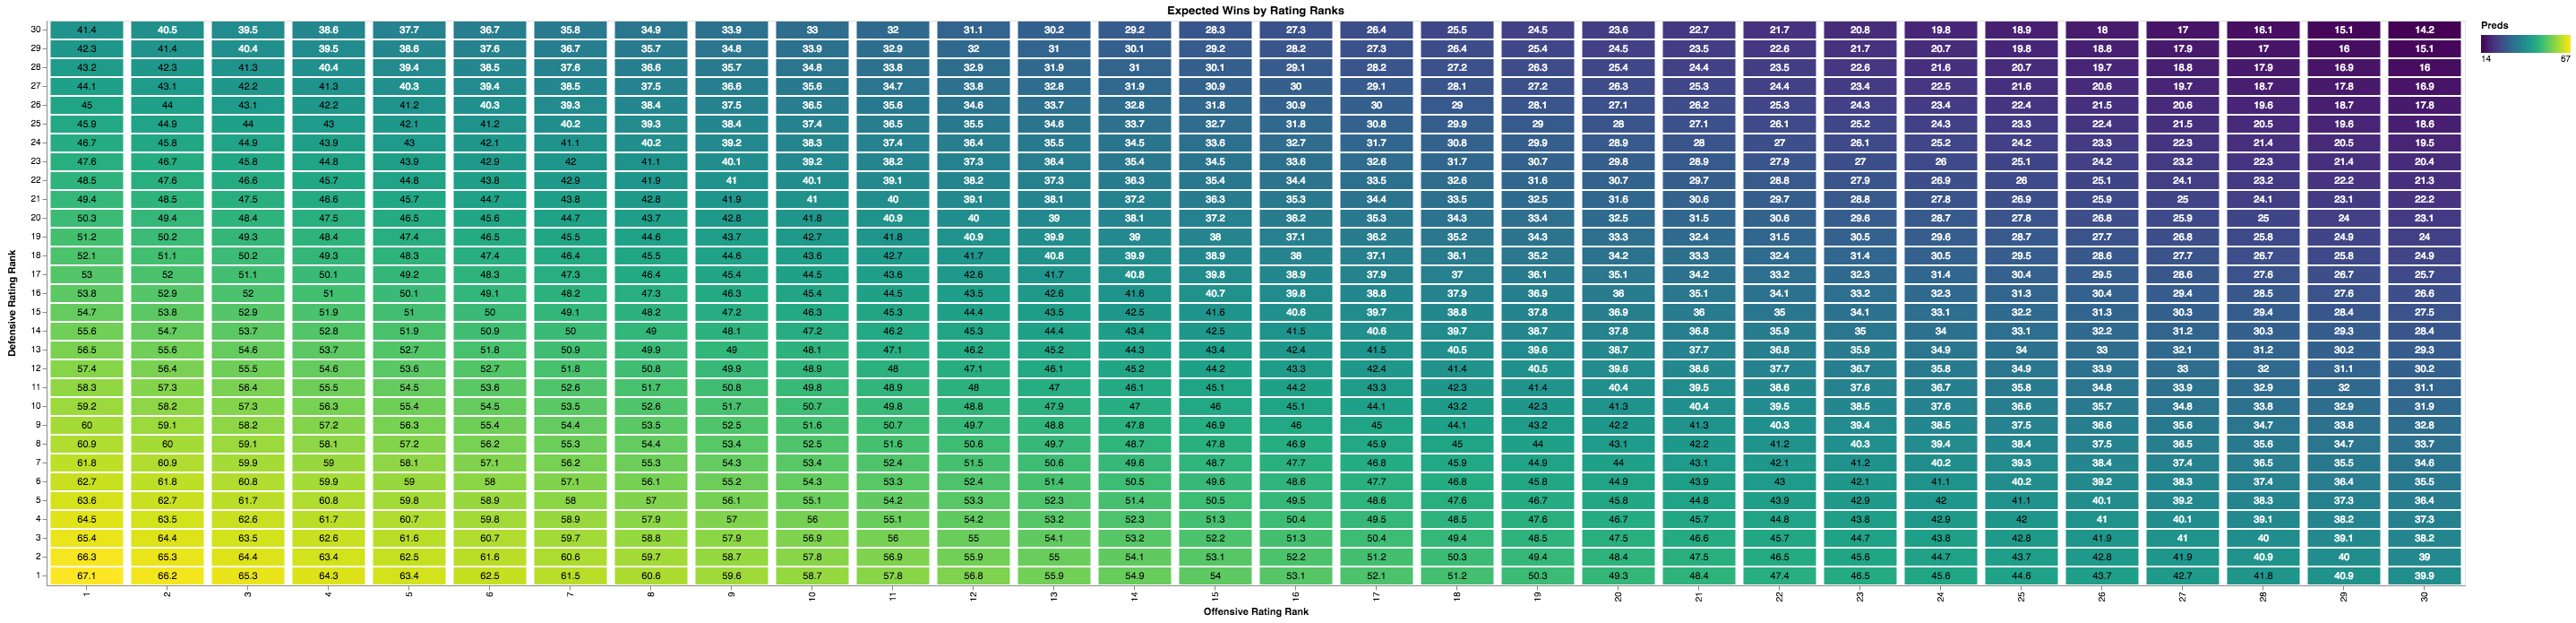

In [14]:
graph = alt.Chart(ranking_wins_df).mark_rect().encode(
    x=alt.X('Off_Rating_Rank:O', axis = alt.Axis(title='Offensive Rating Rank')),
    y=alt.Y('Def_Rating_Rank:O', axis = alt.Axis(title='Defensive Rating Rank'),
            scale=alt.Scale(domain=[x for x in np.arange(30, 0, -1)])),
    color='Preds:Q'
)

text = alt.Chart(ranking_wins_df).mark_text(baseline='middle').encode(
    x='Off_Rating_Rank:O',
    y=alt.Y('Def_Rating_Rank:O', scale=alt.Scale(domain=[x for x in np.arange(30, 0, -1)])),
    text='Preds:Q',
    color = alt.condition(datum.Preds > 41,
                         alt.value('black'),
                         alt.value('white'))
)


graph = graph.properties(title='Expected Wins by Rating Ranks')

graph + text

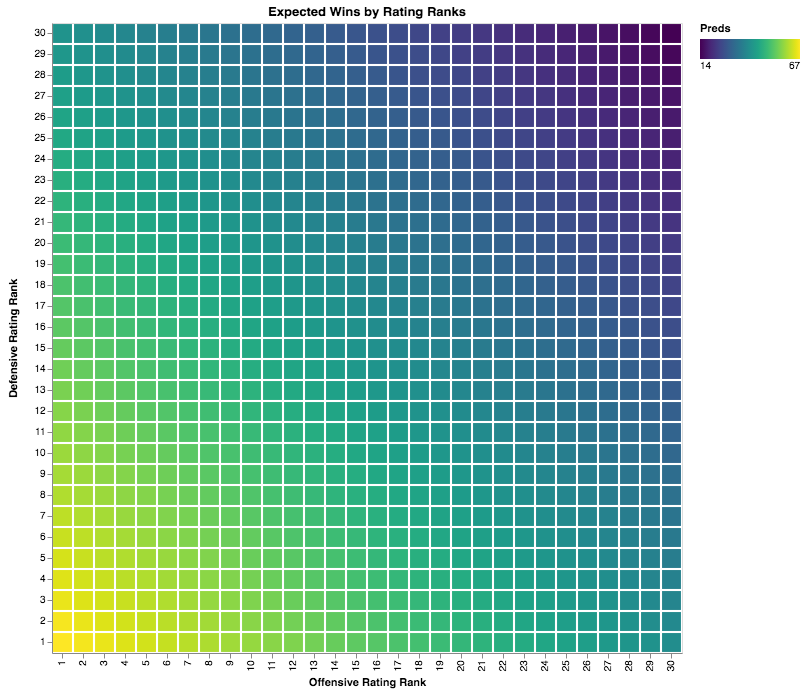

In [15]:
graph

These last two plots are distribution plots for the observed wins and the predicted wins from my regression. I created them to check how true the predicted distribution is to the observed wins distribution in the NBA. It's apparent from the graphs the distributions are different, which stems from two facts. The first is that while the predicted values cover all 900 possible combination of rankings, only 470 of these were observed over the 21 seasons in the dataset. The second is that the assumptions surrounding the linear regression are unlikely to be met by the observed values, potentially rendering the regression useless.

In [26]:
df_new.groupby(['Off_Rating_Rank', 'Def_Rating_Rank']).size().reset_index().shape[0]

470

(8, 75)

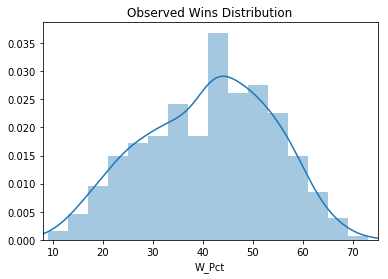

In [19]:
wins_obs = np.round(df_new.W_Pct*82)
g_obs = sns.distplot(wins_obs)
g_obs.set_title('Observed Wins Distribution')
g_obs.set_xlim(8, 75)

(8, 75)

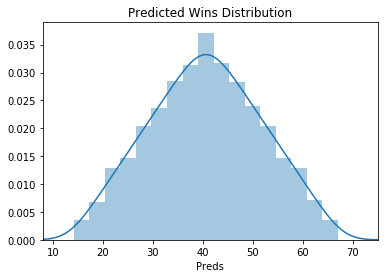

In [18]:
g_pred = sns.distplot(ranking_wins_df.Preds)
g_pred.set_title('Predicted Wins Distribution')
g_pred.set_xlim(8, 75)

However, since this is meant strictly as a guideline, I feel comfortable potentially violating the assumptions and moving forward with the model. There are easily better ways to model expected wins such as using the actual ratings (relative to league average) instead of the rankings, but this is a heuristic and thus won't be subjected to the same level of rigor as other models. Perhaps the most important point here is that the inputs to the model - offensive and defensive rating ranks - are entirely up to you, a human, making it flawed from the start. 